In [1]:
import sys
import torch
import torchvision
import datetime
import os
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/home/ruchitjagodara/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
2024-04-11 16:17:11.528576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-11 16:17:11.737916: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
20

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# VGG (block 1)

In [3]:
class VGG1Block(nn.Module):
  def __init__(self):
    super(VGG1Block, self).__init__()
    self.features = nn.Sequential(
      nn.Conv2d(3, 32, 3, padding=1),
      nn.ReLU(inplace=True),
      nn.MaxPool2d(2, 2)
    )
    self.classifier = nn.Sequential(
      nn.Linear(32 * 128 * 128, 256),
      nn.ReLU(inplace=True),
      nn.Linear(256, 16),
      nn.ReLU(inplace=True),
      nn.Linear(16, 1)
    )

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x


In [4]:
def train_model(model, train_it, epochs=25, lr=0.002):
    optimizer = optim.Adam(model.parameters(), lr)
    criterion = nn.BCEWithLogitsLoss()
    model.to(device)
    model.train()
    for epoch in range(epochs):
        itrr = 0
        loss_val = 0
        for i, (inputs, labels) in enumerate(train_it):
            itrr += 1
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.unsqueeze(1).float()
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_val += loss.item()
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch + 1}, Loss: {loss_val / len(train_it)},    {itrr} iterations')
    return model

def test_model(model, test_it):
    loss_func = nn.BCEWithLogitsLoss()
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    loss = 0
    with torch.no_grad():
        for inputs, labels in test_it:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            labels = labels.unsqueeze(1).float()
            loss += loss_func(outputs, labels).item()
            predicted = outputs>0
            total += labels.size(0)
            for i in range(labels.size(0)):
                if labels[i] == predicted[i]:
                    correct += 1
    print(f'Accuracy of the network on the test images: {100 * correct / total}%')
    return loss, correct / total


In [32]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
train_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
train_it = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
test_it = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)
model = VGG1Block()
xx = datetime.datetime.now()
model = train_model(model, train_it)
yy = datetime.datetime.now()
test_loss, test_accuracy = test_model(model, test_it)
train_loss, train_accuracy = test_model(model, train_it)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}, train time {yy-xx}, train loss: {train_loss}, train accuracy: {train_accuracy}, number of parameters: {sum(p.numel() for p in model.parameters())}')

Epoch 1, Loss: 1.7537997444160283,    40 iterations
Epoch 2, Loss: 0.3503061331808567,    40 iterations
Epoch 3, Loss: 0.1553723952616565,    40 iterations
Epoch 4, Loss: 0.07913346238201484,    40 iterations
Epoch 5, Loss: 0.023411604022840038,    40 iterations
Epoch 6, Loss: 0.007239356741047231,    40 iterations
Epoch 7, Loss: 0.004993102681874006,    40 iterations
Epoch 8, Loss: 0.004515022670693725,    40 iterations
Epoch 9, Loss: 0.004277396107249842,    40 iterations
Epoch 10, Loss: 0.004119428835019789,    40 iterations
Epoch 11, Loss: 0.003987793382066229,    40 iterations
Epoch 12, Loss: 0.003925644389528316,    40 iterations
Epoch 13, Loss: 0.0038810919718116565,    40 iterations
Epoch 14, Loss: 0.0038380085075914393,    40 iterations
Epoch 15, Loss: 0.0037968316659714673,    40 iterations
Epoch 16, Loss: 0.0037693616534852483,    40 iterations
Epoch 17, Loss: 0.003751278322380358,    40 iterations
Epoch 18, Loss: 0.003736251571962157,    40 iterations
Epoch 19, Loss: 0.0037

In [8]:
torch.save(model.state_dict(), 'model.pth')

# VGG (3 block)

In [34]:
class VGG3Block(nn.Module):
    def __init__(self, *args, **kwargs):
        super(VGG3Block, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [35]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
train_it = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
test_it = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)
model = VGG3Block()
xx = datetime.datetime.now()
model = train_model(model, train_it, lr = 0.0012)
yy = datetime.datetime.now()
test_loss, test_accuracy = test_model(model, test_it)
train_loss, train_accuracy = test_model(model, train_it)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}, train time {yy-xx}, train loss: {train_loss}, train accuracy: {train_accuracy}, number of parameters: {sum(p.numel() for p in model.parameters())}')

Epoch 1, Loss: 0.7096438452601432,    40 iterations
Epoch 2, Loss: 0.6007659062743187,    40 iterations
Epoch 3, Loss: 0.4216646829620004,    40 iterations
Epoch 4, Loss: 0.41477681370452046,    40 iterations
Epoch 5, Loss: 0.2333721358969342,    40 iterations
Epoch 6, Loss: 0.12520042896576342,    40 iterations
Epoch 7, Loss: 0.1918211400268774,    40 iterations
Epoch 8, Loss: 0.07912709751449257,    40 iterations
Epoch 9, Loss: 0.1253853606634948,    40 iterations
Epoch 10, Loss: 0.025009070713531402,    40 iterations
Epoch 11, Loss: 0.038703762722025206,    40 iterations
Epoch 12, Loss: 0.014638983476288558,    40 iterations
Epoch 13, Loss: 0.002105598138065723,    40 iterations
Epoch 14, Loss: 0.00037931466224701006,    40 iterations
Epoch 15, Loss: 0.00024809477284324364,    40 iterations
Epoch 16, Loss: 0.000175132684173418,    40 iterations
Epoch 17, Loss: 0.0025165103138343526,    40 iterations
Epoch 18, Loss: 0.0012889734608069413,    40 iterations
Epoch 19, Loss: 0.0001198221

In [35]:
torch.save(model.state_dict(), 'model2.pth')

# VGG (3 block with data augmentation)

## data augmentation

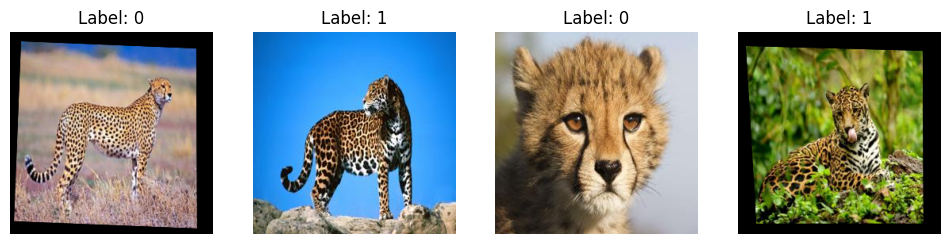

In [9]:
import numpy as np
transform_aug = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.ToTensor(),
    transforms.RandomGrayscale(0.1),
    transforms.RandomPerspective(0.2, 0.2),
    transforms.RandomVerticalFlip(0.2),
])
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_data_aug = torchvision.datasets.ImageFolder(root='data/train', transform=transform_aug)
train_it_aug = torch.utils.data.DataLoader(train_data_aug, batch_size=4, shuffle=True)
train_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
train_it = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
test_it = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

import matplotlib.pyplot as plt
images, labels = next(iter(train_it_aug))

# Plot the images
fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
for i, image in enumerate(images):
    image_np = np.transpose(image.numpy(), (1, 2, 0))
    axes[i].imshow(image_np)
    axes[i].set_title(f"Label: {labels[i]}")
    axes[i].axis('off')

plt.show()


In [36]:
model3 = VGG3Block()
xx = datetime.datetime.now()
model3 = train_model(model3, train_it, lr = 0.0009)
yy = datetime.datetime.now()
test_loss, test_accuracy = test_model(model3, test_it)
train_loss, train_accuracy = test_model(model3, train_it)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}, train time {yy-xx}, train loss: {train_loss}, train accuracy: {train_accuracy}, number of parameters: {sum(p.numel() for p in model.parameters())}')

Epoch 1, Loss: 0.6988350510597229,    40 iterations
Epoch 2, Loss: 0.5994199596345424,    40 iterations
Epoch 3, Loss: 0.5076967306435108,    40 iterations
Epoch 4, Loss: 0.3550624861381948,    40 iterations
Epoch 5, Loss: 0.16646360142622144,    40 iterations
Epoch 6, Loss: 0.16420197759871372,    40 iterations
Epoch 7, Loss: 0.22359180460916833,    40 iterations
Epoch 8, Loss: 0.14048491028952412,    40 iterations
Epoch 9, Loss: 0.03615273026916839,    40 iterations
Epoch 10, Loss: 0.03752573755355115,    40 iterations
Epoch 11, Loss: 0.007184412382321171,    40 iterations
Epoch 12, Loss: 0.01863354622624911,    40 iterations
Epoch 13, Loss: 0.001959924945185776,    40 iterations
Epoch 14, Loss: 0.0008371070985361939,    40 iterations
Epoch 15, Loss: 0.0003286095689347235,    40 iterations
Epoch 16, Loss: 0.00027265160218945537,    40 iterations
Epoch 17, Loss: 0.0001712777032963686,    40 iterations
Epoch 18, Loss: 8.927390902595534e-05,    40 iterations
Epoch 19, Loss: 5.9027817585

In [54]:
torch.save(model3.state_dict(), 'model3.pth')

Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 0, True: 0
Predicted: 1, True: 1
Predicted: 0, True: 1


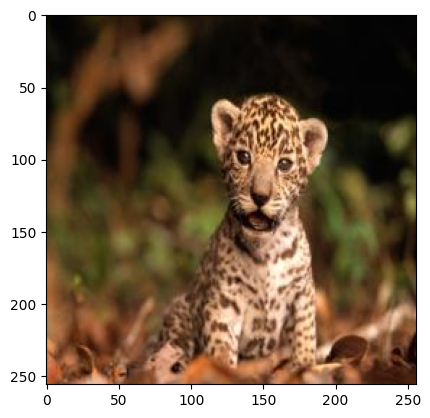

Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 1


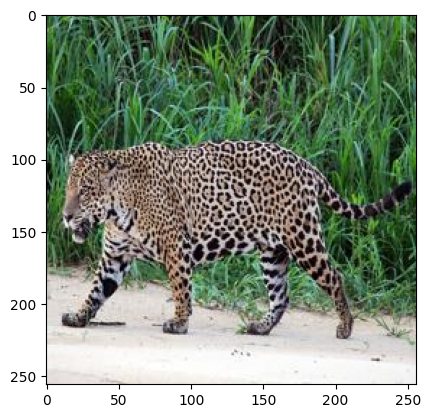

Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 1


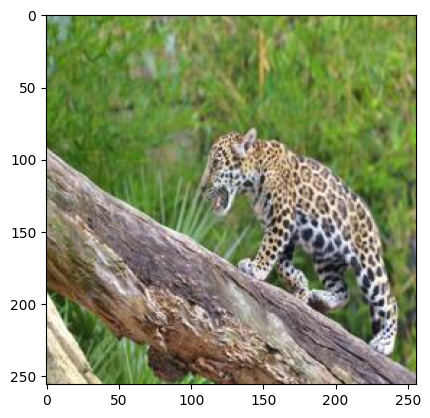

Predicted: 0, True: 1


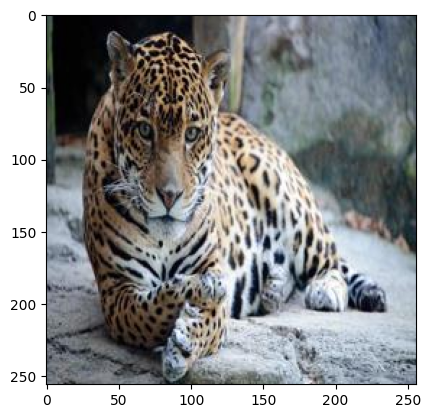

Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 0, True: 1


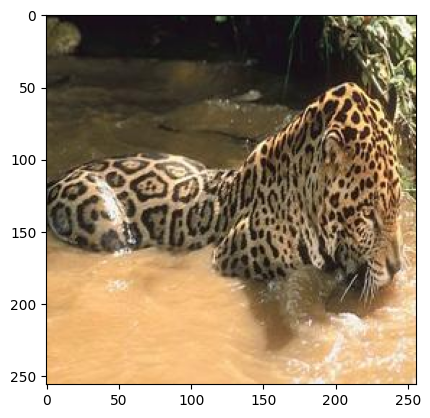

Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1
Predicted: 1, True: 1


In [13]:
import numpy as np
predicted = []
output = []
train = []
for x,y in test_it:
    train += x.to(device).to('cpu').detach().numpy().tolist()
    predicted += model3(x.to(device)).to('cpu').detach().numpy().tolist()
    output += y
for i in range(len(predicted)):
    ans = int(predicted[i][0]>0)
    print(f'Predicted: {ans}, True: {output[i]}')
    if (ans!=output[i]):
        # Reshape the image
        reshaped_image = np.transpose(train[i], (1, 2, 0))
        # Plot the image
        plt.imshow(reshaped_image)
        plt.show()

torch.Size([1, 3, 256, 256])
Predicted: True
True: tensor([1])


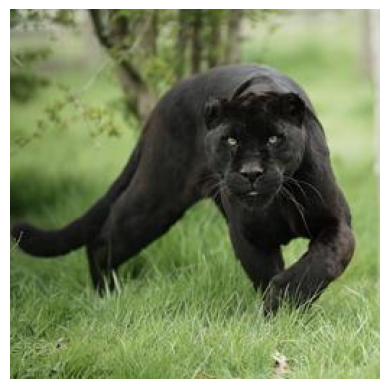

In [6]:
import numpy as np
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
tester = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
tester_it = torch.utils.data.DataLoader(tester, batch_size=1, shuffle=False)
label = 0
itrr = iter(tester_it)
while (label==0):
    image, label = next(itrr)
print(image.shape)
model = VGG3Block()
model_state_dict = torch.load('model3.pth')
model.to(device)
model.eval()
model.load_state_dict(model_state_dict)
output = model(image.to(device))
print(f'Predicted: {(output[0][0]>0)}')
print(f'True: {label}')
import matplotlib.pyplot as plt


image_np = (image.numpy())
image_np = image_np.transpose((2, 3, 1, 0)).squeeze()
# Plot the image
plt.imshow(image_np)
plt.axis('off')
plt.show()


# Transfer learning using VGG16 and tuning only final mlp layers

In [11]:
from torchvision.models import vgg16

class VGG16_tl(nn.Module):
    def __init__(self):
        super(VGG16_tl, self).__init__()
        self.base_model = vgg16(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

In [25]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
train_it = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
test_it = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

In [37]:
model = VGG16_tl()
xx = datetime.datetime.now()
model = train_model(model, train_it, lr = 0.00005)
yy = datetime.datetime.now()
test_loss, test_accuracy = test_model(model, test_it)
train_loss, train_accuracy = test_model(model, train_it)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}, train time {yy-xx}, train loss: {train_loss}, train accuracy: {train_accuracy}, number of parameters: {sum(p.numel() for p in model.parameters())}')

/home/ruchitjagodara/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ruchitjagodara/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.5786522060632706,    40 iterations
Epoch 2, Loss: 0.32794468365609647,    40 iterations
Epoch 3, Loss: 0.20710911992937325,    40 iterations
Epoch 4, Loss: 0.13612942518666388,    40 iterations
Epoch 5, Loss: 0.1069887145422399,    40 iterations
Epoch 6, Loss: 0.07065226286649703,    40 iterations
Epoch 7, Loss: 0.07182035346049816,    40 iterations
Epoch 8, Loss: 0.05643735388293862,    40 iterations
Epoch 9, Loss: 0.07546180085046217,    40 iterations
Epoch 10, Loss: 0.0548565462930128,    40 iterations
Epoch 11, Loss: 0.04834513978566975,    40 iterations
Epoch 12, Loss: 0.04195685142185539,    40 iterations
Epoch 13, Loss: 0.039525478589348496,    40 iterations
Epoch 14, Loss: 0.049608264252310616,    40 iterations
Epoch 15, Loss: 0.043108712387038395,    40 iterations
Epoch 16, Loss: 0.04824672678369098,    40 iterations
Epoch 17, Loss: 0.04886321659141686,    40 iterations
Epoch 18, Loss: 0.04641695273749065,    40 iterations
Epoch 19, Loss: 0.027060909938882105,

In [30]:
torch.save(model, 'model4.pth')

# Transfer learning using VGG16 and tuning all layers

In [5]:
from torchvision.models import vgg16

class VGG16_tl_all(nn.Module):
    def __init__(self):
        super(VGG16_tl_all, self).__init__()
        self.base_model = vgg16(pretrained=True)
        self.classifier = nn.Sequential(
            nn.Linear(1000, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 16),
            nn.ReLU(inplace=True),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

In [7]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_data = torchvision.datasets.ImageFolder(root='data/train', transform=transform)
train_it = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)
test_data = torchvision.datasets.ImageFolder(root='data/test', transform=transform)
test_it = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=False)

In [8]:
model = VGG16_tl_all()
xx = datetime.datetime.now()
model = train_model(model, train_it, lr = 0.0001)
yy = datetime.datetime.now()
test_loss, test_accuracy = test_model(model, test_it)
train_loss, train_accuracy = test_model(model, train_it)
print(f'Test loss: {test_loss}, Test accuracy: {test_accuracy}, train time {yy-xx}, train loss: {train_loss}, train accuracy: {train_accuracy}, number of parameters: {sum(p.numel() for p in model.parameters())}')

Epoch 1, Loss: 0.48758009378798306,    40 iterations
Epoch 2, Loss: 0.40475631107641447,    40 iterations
Epoch 3, Loss: 0.17087720305037807,    40 iterations
Epoch 4, Loss: 0.1629467685195166,    40 iterations
Epoch 5, Loss: 0.19624365258919169,    40 iterations
Epoch 6, Loss: 0.13548821617021645,    40 iterations
Epoch 7, Loss: 0.008805843455677342,    40 iterations
Epoch 8, Loss: 7.801383889427527e-05,    40 iterations
Epoch 9, Loss: 1.322552570637292e-05,    40 iterations
Epoch 10, Loss: 1.0132935667739318e-05,    40 iterations
Epoch 11, Loss: 1.58764547750323e-05,    40 iterations
Epoch 12, Loss: 1.2938006915907963e-05,    40 iterations
Epoch 13, Loss: 6.533851632495314e-06,    40 iterations
Epoch 14, Loss: 2.0279937842371254e-06,    40 iterations
Epoch 15, Loss: 5.488486368498968e-06,    40 iterations
Epoch 16, Loss: 3.7808513818848866e-06,    40 iterations
Epoch 17, Loss: 4.942757387160768e-06,    40 iterations
Epoch 18, Loss: 3.374091214514152e-06,    40 iterations
Epoch 19, Lo

In [9]:
torch.save(model, 'model5.pth')

# Table for Model Comparison

$$
\begin{aligned}
& \text {Model Comparison Table}\\
&\begin{array}{cccc}
\hline \hline \text { Model } & \text { Training time } & \text { Training loss } & \text { Training Accuracy } & \text { Testing accuracy } & \text { No. of Model para. } \\
\hline VGG1block & 1:18 & 0.146 & 100 & 95 & 134,223,009 \\
VGG3Block & 0:31 & 0.0009 & 100 & 90 & 33,652,065 \\
VGG3Block\ (data aug) & 0:31 & 0.0001 & 100 & 92.5 & 33,652,065 \\
VGG16\ final\ MLP & 1:02 & 0.998 & 99.375 & 97.5 & 138,617,929 (260,385) \\
VGG16\ all & 3:30 & 2.62e-05 & 100 & 100 &  138,487,753\\
MLP\ Model & 19:07 & 0.6606 & 50 & 50 &  148,734,612\\
\hline
\end{array}
\end{aligned}
$$